<center><img src=https://github.com/nccr-itmo/FEDOT/raw/master/docs/fedot_logo.png></img></center>

# <center>Решение задачи классификации мультимодальных данных при помощи фреймворка [FEDOT](https://github.com/nccr-itmo/FEDOT)</center>

# Введение

**FEDOT** - это фреймворк автоматического машинного обучения с открытым исходным кодом, который способен автоматизировать создание и оптимизацию пайплайнов машинного обучения и их элементов. 
Фреймворк позволяет компактно и эффективно решать различные задачи моделирования.

**Мультимодальные данные** - это данные, которые имеют различную природу (таблицы, текст, изображения, временные ряды). Люди воспринимают мир [мультимодально](https://ru.wikipedia.org/wiki/%D0%AD%D1%84%D1%84%D0%B5%D0%BA%D1%82_%D0%9C%D0%B0%D0%BA-%D0%93%D1%83%D1%80%D0%BA%D0%B0), поэтому использование такого подхода в машинном обучении тоже может сработать. И действительно, как правило, совместное использование нескольких видов данных улучшает качество модели за счёт информации, которая может содержаться в одной модальности и отсутствовать в другой. 

### Установка FEDOT

На данный момент мультимодальный функционал API FEDOT ещё не вышел в релиз, поэтому установим последнюю версию из master ветки репозитория:

In [1]:
!pip install --quiet --upgrade --force-reinstall --no-warn-script-location --no-cache-dir https://github.com/nccr-itmo/FEDOT/archive/master.zip

<div class="alert alert-block alert-info"><b>Примечание</b>: существуют альтернативные способы установки фреймворка и его зависимостей, с которыми можно ознакомится в разделе <b><a href="https://fedot.readthedocs.io/en/latest/introduction/tutorial/quickstart.html">Quickstart</a></b> в нашей документации.</div>

## Данные

В качестве примера возьмём подготовленные данные из датасета [Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews) (winemag-data_first150k). Для удобства и скорости работы сокращено число строк и классов, какой-либо другой предобработки не проводилось (предоставим это Федоту).

Загрузим данные из репозитория:

In [2]:
!wget https://raw.githubusercontent.com/nccr-itmo/FEDOT/master/examples/data/multimodal_wine.csv

--2022-10-14 15:46:12--  https://raw.githubusercontent.com/nccr-itmo/FEDOT/master/examples/data/multimodal_wine.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271972 (266K) [text/plain]
Saving to: ‘multimodal_wine.csv.1’

multimodal_wine.csv 100%[===================>] 265.60K  --.-KB/s    in 0.1s    

2022-10-14 15:46:12 (2.45 MB/s) - ‘multimodal_wine.csv.1’ saved [271972/271972]



Поле **description** содержит текстовое описание различных сортов вина, целевой переменной является поле **variety**.

In [3]:
import pandas as pd

df = pd.read_csv('multimodal_wine.csv')
df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
2,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
3,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm
4,US,"From 18-year-old vines, this supple well-balan...",Estate Vineyard Wadensvil Block,95,48.0,Oregon,Ribbon Ridge,Willamette Valley,Pinot Noir,Patricia Green Cellars
...,...,...,...,...,...,...,...,...,...,...
774,US,"This is a rich, broad-shouldered Pinot Noir, w...",Brown Ranch,88,72.0,California,Carneros,Napa-Sonoma,Pinot Noir,Saintsbury
775,US,"A delicate, almost fragile wine, this opens wi...",Arbre Vert Vineyard,88,42.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Siduri
776,US,"Even with some hours of breathing time, this r...",La Colina Vineyard,88,60.0,Oregon,Dundee Hills,Willamette Valley,Pinot Noir,Torii Mor
777,US,"Loaded with scents and flavors of chocolate, m...",Shea Vineyard,88,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Walt


Данные загружены. Теперь можно опробовать несколько вариантов решения.

## Использование мультимодального функционала FEDOT

Решить данную задачу классификации при помощи FEDOT можно при помощи нескольких строк кода. Сначала импортируем необходимые модули и классы, а также разобьём выборку на train и test части.

FEDOT автоматически определит поле **description** как текстовое и будет применять к нему различные модели обработки текста. Также следует указать на колонку с целевой переменной **variety** и на отсутствие в данных отдельной колонки-индекса.

In [4]:
from fedot.api.main import Fedot
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.data.multi_modal import MultiModalData

data = MultiModalData.from_csv(file_path='multimodal_wine.csv', task='classification', target_columns='variety', index_col=None)
fit_data, predict_data = train_test_data_setup(data, shuffle_flag=True, split_ratio=0.7)

Зададим параметры AutoML-модели.

In [5]:
automl_model = Fedot(problem='classification', timeout=10, seed=42)

* `problem = 'classification'` - задача, решаемая фреймворком
* `timeout = 3` - время работы фреймворка в минутах
* `seed = 42` - для воспроизводимости зафиксируем сид

<div class="alert alert-block alert-info"><b>Примечание</b>: существуют также и другие параметры для запуска FEDOT. Более подробнее можно ознакомится в разделе <b><a href="https://fedot.readthedocs.io/en/latest/api/api.html">FEDOT API</a></b> в нашей документации.</div>

Далее можно приступить к запуску процесса поиска оптимального пайплайна и его обучения. Необходимо в метод `.fit()` передать данные для обучения.

In [6]:
automl_model.fit(features=fit_data,
                  target=fit_data.target)

2022-10-14 15:46:15,963 - ApiComposer - Initial pipeline was fitted in 1.1 sec.
2022-10-14 15:46:15,970 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 10 min Set of candidate models: ['bernb', 'dt', 'knn', 'lgbm', 'logit', 'mlp', 'qda', 'rf', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'isolation_forest_class', 'resample']
2022-10-14 15:46:16,011 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


2022-10-14 15:52:02,732 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [05:46<?, ?gen/s]

2022-10-14 15:52:02,738 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


  0%|          | 194/100000 [04:12<36:02:49,  1.30s/trial, best loss: -0.973762]         
2022-10-14 15:56:16,714 - ApiComposer - Hyperparameters tuning finished
2022-10-14 15:56:16,840 - ApiComposer - Model generation finished
2022-10-14 15:56:17,065 - FEDOT logger - Final pipeline was fitted
2022-10-14 15:56:17,067 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [rf, tfidf, data_source_text/description, data_source_table]}


{'depth': 3, 'length': 4, 'nodes': [rf, tfidf, data_source_text/description, data_source_table]}

Выше указана структура пайплайна в текстовом виде. Для визуализации воспользуемся методом `.show()`.

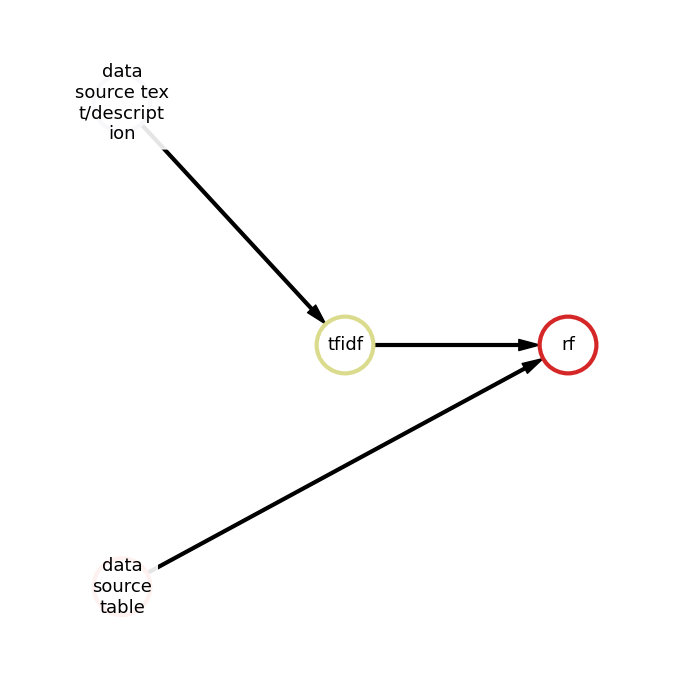

In [7]:
automl_model.current_pipeline.show(node_size_scale=0.5, dpi=100)

Предскажем целевую переменную и сравним метрики.

In [8]:
prediction = automl_model.predict(predict_data)

metrics = automl_model.get_metrics()

metrics

{'roc_auc': 0.964, 'f1': 0.8063232642802113}

Визуализируем метрику.

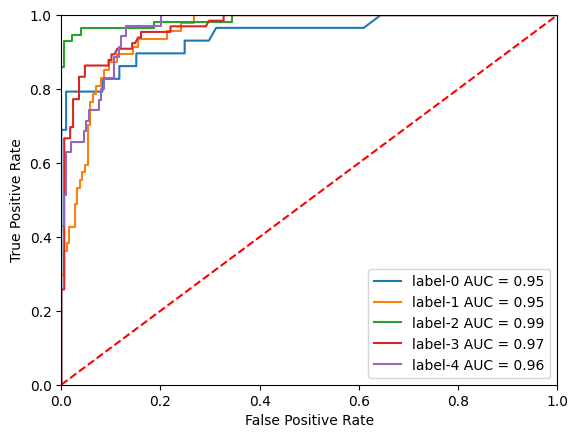

In [9]:
automl_model.plot_prediction()

Сохраним историю процесса генерации в формате JSON.

In [10]:
automl_model.history.save('multimodal_history.json');

Используя историю, можно посмотреть на изменение значения метрик для каждого этапа генерации. FEDOT использует эволюционные алгоритмы и в каждом поколении генерации сравнивает метрики нескольких пайплайнов-индивидов, поэтому оптимальный способ визуализации - боксплот, где средняя линия означает медианное значение метрики в поколении.

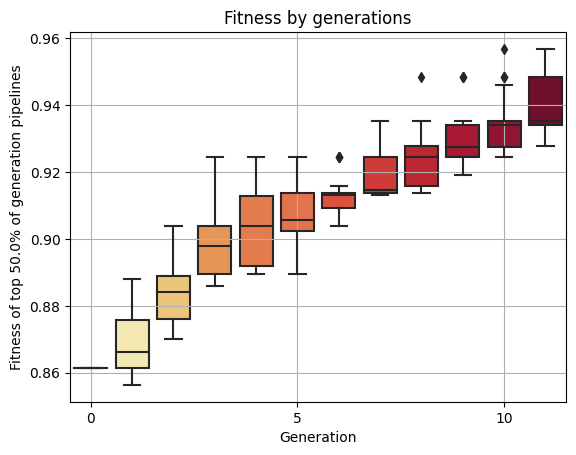

In [11]:
automl_model.history.show.fitness_box(best_fraction=0.5, dpi=100)

Также можно посмотреть на то, какие конкретные модели преобладали в пайплайнах в процессе генерации.

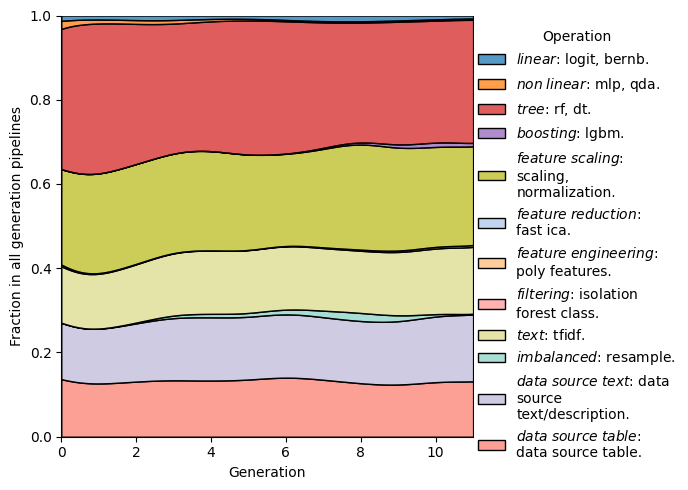

In [12]:
automl_model.history.show.operations_kde(dpi=100)

### Baseline

Для сравнения качества модели запустим FEDOT на тех же данных, но обучив только стандартный начальный пайплайн.

In [13]:
baseline_model = Fedot(problem='classification', seed=42)
baseline_model.fit(features=fit_data,
                 target=fit_data.target,
                 predefined_model='auto')

2022-10-14 15:56:25,266 - FEDOT logger - Final pipeline: {'depth': 5, 'length': 8, 'nodes': [rf, rf, scaling, tfidf, data_source_text/description, rf, scaling, data_source_table]}


{'depth': 5, 'length': 8, 'nodes': [rf, rf, scaling, tfidf, data_source_text/description, rf, scaling, data_source_table]}

Параметр `timeout` в данном случае не используется, поэтому уберём его. Параметр `predefined_model` указывает, что мы не будем запускать AutoML, а просто обучим модель на стандартном начальном пайплайне.

Визуализируем пайплайн.

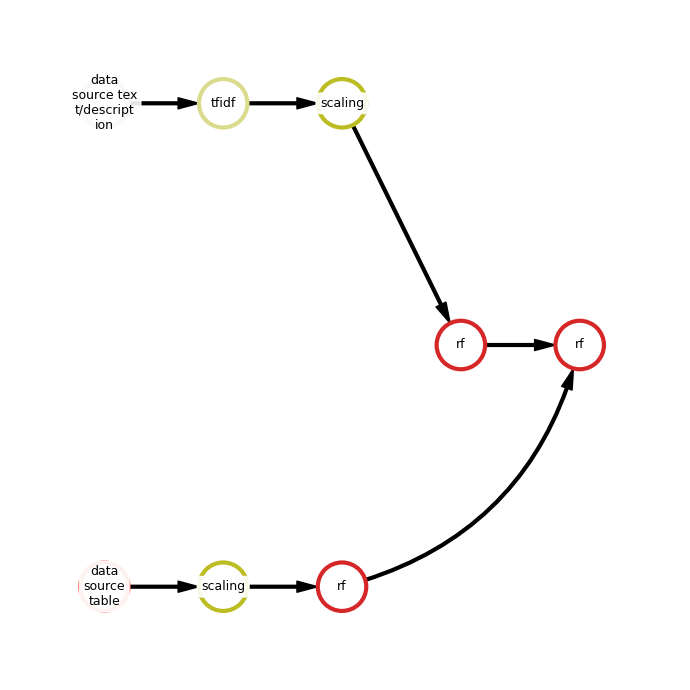

In [14]:
baseline_model.current_pipeline.show(node_size_scale=0.5, dpi=100)

Получим и сравним метрики. Заметно, что даже небольшое время обучения значительно улучшает метрики качества.

In [15]:
prediction = baseline_model.predict(predict_data)

baseline_metrics = baseline_model.get_metrics()

baseline_metrics

{'roc_auc': 0.901, 'f1': 0.6568868132143566}

### Только табличные данные

Чтобы удостовериться в значимости обеих модальностей, обучим базовую модель только на табличных данных. Для этого просто исключим текстовое поле **description** при загрузке данных. 

In [16]:
table_data = MultiModalData.from_csv(file_path='multimodal_wine.csv', task='classification', target_columns='variety', 
                                     columns_to_drop=['description'], index_col=None)
table_fit_data, table_predict_data = train_test_data_setup(table_data, shuffle_flag=True, split_ratio=0.7)

In [17]:
table_model = Fedot(problem='classification', seed=42)
table_model.fit(features=table_fit_data,
                 target=table_fit_data.target,
                 predefined_model='auto')

2022-10-14 15:56:26,734 - FEDOT logger - Final pipeline: {'depth': 4, 'length': 4, 'nodes': [rf, rf, scaling, data_source_table]}


{'depth': 4, 'length': 4, 'nodes': [rf, rf, scaling, data_source_table]}

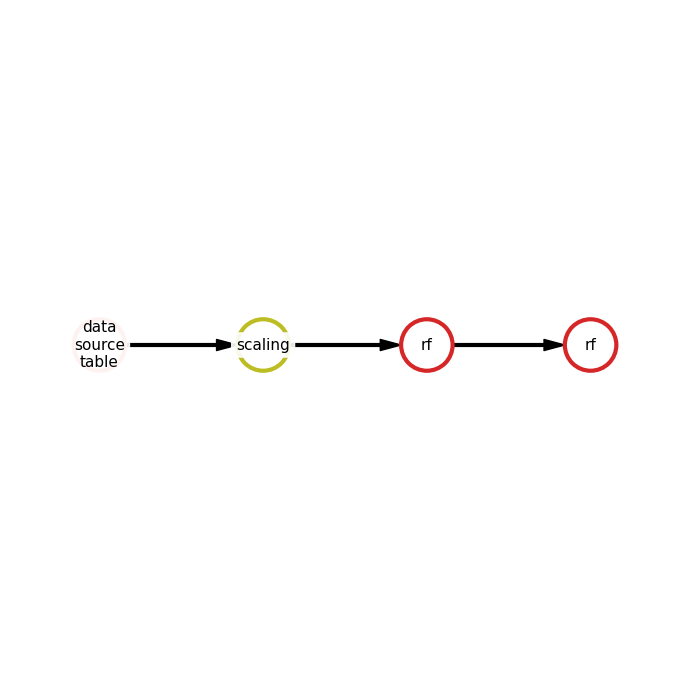

In [18]:
table_model.current_pipeline.show(node_size_scale=0.5, dpi=100)

Заметно, что метрики такой модели заметно хуже, чем мультимодальной.

In [19]:
prediction = table_model.predict(table_predict_data)

table_metrics = table_model.get_metrics()

table_metrics

{'roc_auc': 0.847, 'f1': 0.6293384469407217}

### Метрики

Сравним метрики AutoML-модели, мультимодального бейзлайна и табличного бейзлайна.

In [20]:
print(f'ROC-AUC of AutoML model is {round(metrics["roc_auc"], 3)}')
print(f'ROC-AUC of baseline model is {round(baseline_metrics["roc_auc"], 3)}')
print(f'ROC-AUC of baseline table model is {round(table_metrics["roc_auc"], 3)}')


ROC-AUC of AutoML model is 0.964
ROC-AUC of baseline model is 0.901
ROC-AUC of baseline table model is 0.847


In [21]:
print(f'F1 of AutoML model is {round(metrics["f1"], 3)}')
print(f'F1 of baseline model is {round(baseline_metrics["f1"], 3)}')
print(f'F1 of baseline table model is {round(table_metrics["f1"], 3)}')

F1 of AutoML model is 0.806
F1 of baseline model is 0.657
F1 of baseline table model is 0.629


## Послесловие

В данном блокноте мы показали вам, как запустить фреймворк **FEDOT** для решения задачи классификации с использованием мультимодальных данных при помощи API. Как можно заметить, это делается совсем просто.

Теперь и вы можете попробовать запустить фреймворк автоматического машинного обучения **FEDOT** на своих данных.

<i class="fa fa-github" style="font-size:24px"></i> - <a href="https://github.com/nccr-itmo/FEDOT"> Наш репозиторий </a>

<i class="fa fa-telegram" style="font-size:24px;color:blue"></i> - <a href="https://t.me/FEDOT_helpdesk">Telegram канал поддержки</a>

<i class="fa fa-youtube-play" style="font-size:24px;color:red"></i> - <a href="https://www.youtube.com/channel/UC4K9QWaEUpT_p3R4FeDp5jA">Наш канал на Youtube</a>